## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [42]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [44]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

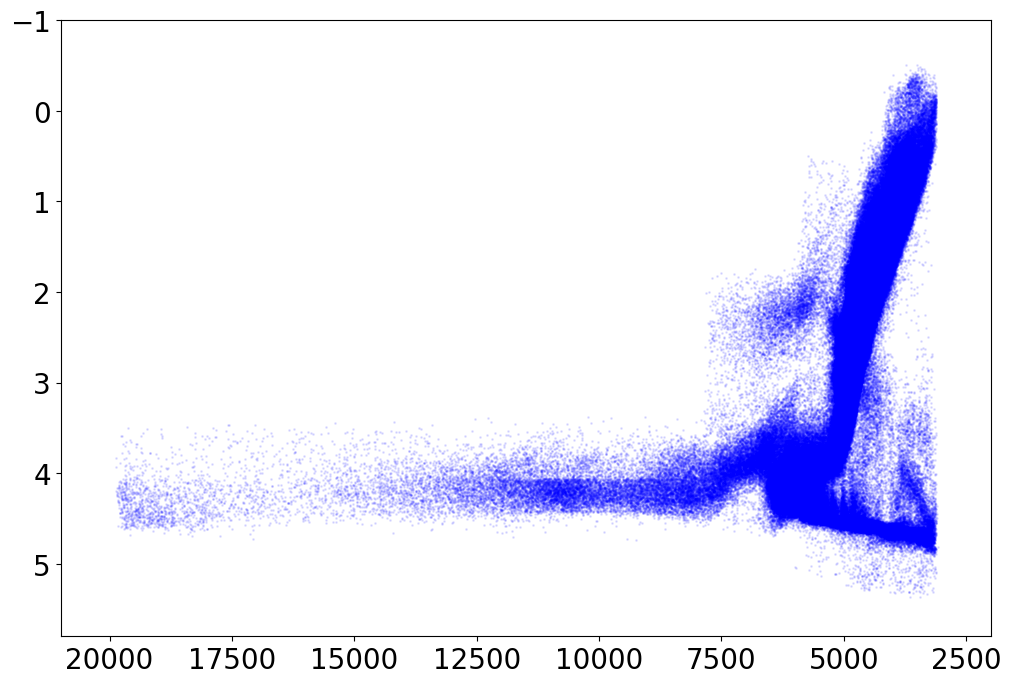

In [45]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 0.055, 19.936
POLY2: 0.003, -1.174, 126.287
POLY3: 0.000, -0.000, -0.651, 101.052


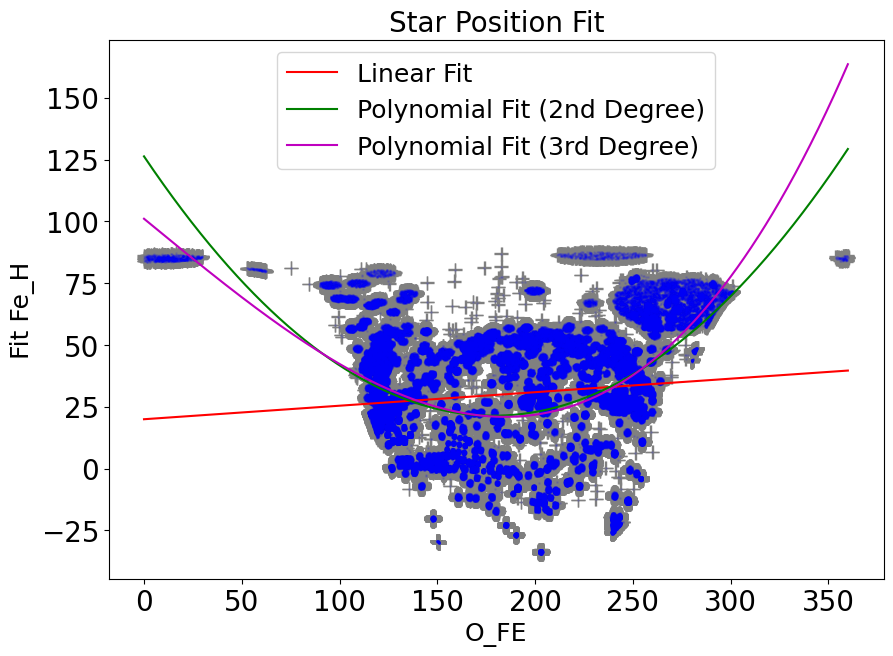

In [4]:
import numpy as np
import matplotlib.pyplot as plt



badbits = 2**23       
suspectbits = 2**16    


ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star['GLAT'] > 20)  
cut1 = np.where(ct1)[0]


slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                          star['RA'][cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')


poly2A, poly2B, poly2C = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                                 star['RA'][cut1]/1000, p0=[600,1,1])
print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')


poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                                         star['RA'][cut1]/1000, p0=[1,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')


fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(star['RA'][cut1], star['DEC'][cut1], s=1, c='b', alpha=0.1)


ra_errors = np.abs(star['RA'][cut1] / 1000)  
dec_errors = np.abs(star['DEC'][cut1] / 1000)  

ax1.errorbar(star['RA'][cut1], star['DEC'][cut1], xerr=ra_errors, yerr=dec_errors, 
             ecolor='grey', fmt='none', capsize=5, zorder=0)

ax1.set_xlabel('O_FE', fontsize=18)
ax1.set_ylabel('Fit Fe_H', fontsize=18)
ax1.set_title('Star Position Fit', fontsize=20)


x_plot = np.linspace(0, 360, 1000)  
ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Linear Fit', color='r')
ax1.plot(x_plot, poly2(x_plot, poly2A, poly2B, poly2C), label='Polynomial Fit (2nd Degree)', color='g')
ax1.plot(x_plot, poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Polynomial Fit (3rd Degree)', color='m')


plt.legend(loc='best', fontsize=18)


plt.show()



## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.047, 9.959
POLY2: 0.005, -1.917, 132.576
POLY3: 0.000, 0.001, -1.287, 109.151


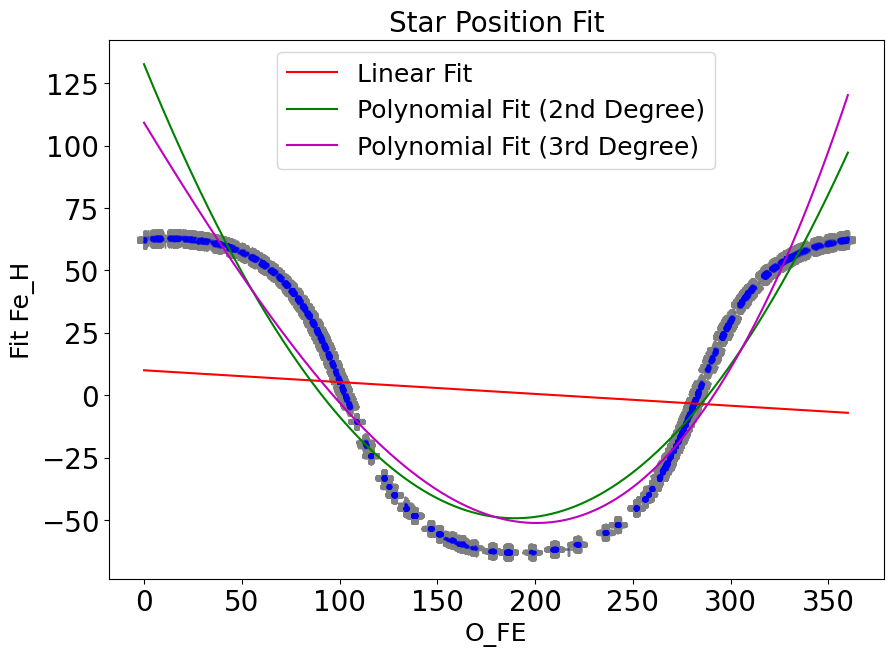

In [37]:
import numpy as np
import matplotlib.pyplot as plt




badbits = 2**23      
suspectbits = 2**16    


ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
      (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
      (star['GLAT'] < 1) &\
     (star['GLAT'] > -1)   
cut1 = np.where(ct1)[0]


slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                          star['RA'][cut1]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')


poly2A, poly2B, poly2C = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                                 star['RA'][cut1]/1000, p0=[600,1,1])
print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')


poly3A, poly3B, poly3C, poly3D = mcFit4(poly3, star['RA'][cut1], star['DEC'][cut1], star['RA'][cut1]/1000, \
                                         star['RA'][cut1]/1000, p0=[1,1,1,1])
print(f'POLY3: {poly3A:.3f}, {poly3B:.3f}, {poly3C:.3f}, {poly3D:.3f}')


fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(star['RA'][cut1], star['DEC'][cut1], s=1, c='b', alpha=0.1)


ra_errors = np.abs(star['RA'][cut1] / 1000)  
dec_errors = np.abs(star['DEC'][cut1] / 1000)  

ax1.errorbar(star['RA'][cut1], star['DEC'][cut1], xerr=ra_errors, yerr=dec_errors, 
             ecolor='grey', fmt='none', capsize=5, zorder=0)

ax1.set_xlabel('O_FE', fontsize=18)
ax1.set_ylabel('Fit Fe_H', fontsize=18)
ax1.set_title('Star Position Fit', fontsize=20)


x_plot = np.linspace(0, 360, 1000) 
ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Linear Fit', color='r')
ax1.plot(x_plot, poly2(x_plot, poly2A, poly2B, poly2C), label='Polynomial Fit (2nd Degree)', color='g')
ax1.plot(x_plot, poly3(x_plot, poly3A, poly3B, poly3C, poly3D), label='Polynomial Fit (3rd Degree)', color='m')


plt.legend(loc='best', fontsize=18)

plt.show()

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: 462.560, 3569.027
POLY2: -162.953, 1327.487, 2683.941
EXPONENTIAL: -3107.024, -0.447, 5902.820


/var/folders/9k/kpqg1w5j7clgxg71m8mmk2nr0000gn/T/ipykernel_71372/2016141294.py:13: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x) + c
/var/folders/9k/kpqg1w5j7clgxg71m8mmk2nr0000gn/T/ipykernel_71372/2016141294.py:13: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(b * x) + c


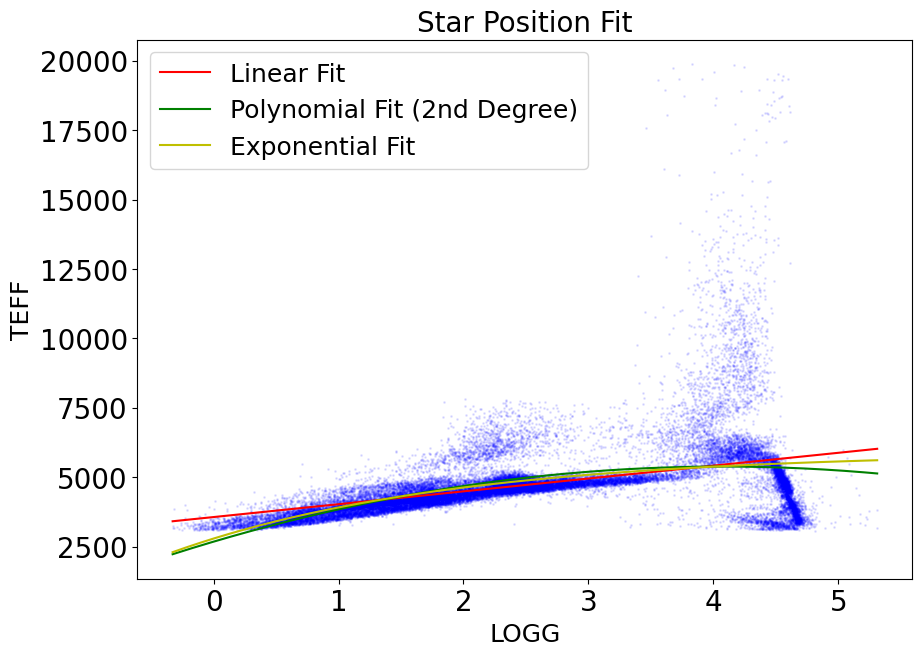

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def linear(x, a, b):
    return a * x + b

def polynomial2(x, a, b, c):
    return a * x**2 + b * x + c

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c


ct1 = (star['GLON'] > 340) & (star['GLON'] < 360)
cut1 = np.where(ct1)[0]


logg_data = star['LOGG'][cut1]
teff_data = star['TEFF'][cut1]

valid_indices = ~np.isnan(logg_data) & ~np.isnan(teff_data) & ~np.isinf(logg_data) & ~np.isinf(teff_data)

logg_clean = logg_data[valid_indices]
teff_clean = teff_data[valid_indices]


initial_guess_linear = [1, 0]  

params_linear, _ = curve_fit(linear, logg_clean, teff_clean, p0=initial_guess_linear)

slope = params_linear[0]
intercept = params_linear[1]

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')


initial_guess_poly2 = [1, 1, 1]  

params_poly2, _ = curve_fit(polynomial2, logg_clean, teff_clean, p0=initial_guess_poly2)

poly2A = params_poly2[0]
poly2B = params_poly2[1]
poly2C = params_poly2[2]

print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')


initial_guess_exp = [1, -0.01, 5000] 

params_exp, _ = curve_fit(exponential, logg_clean, teff_clean, p0=initial_guess_exp)

exp_params_a = params_exp[0]
exp_params_b = params_exp[1]
exp_params_c = params_exp[2]

print(f'EXPONENTIAL: {exp_params_a:.3f}, {exp_params_b:.3f}, {exp_params_c:.3f}')


fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(logg_clean, teff_clean, s=1, c='b', alpha=0.1)


ax1.set_xlabel('LOGG', fontsize=18)
ax1.set_ylabel('TEFF', fontsize=18)
ax1.set_title('Star Position Fit', fontsize=20)


x_plot = np.linspace(min(logg_clean), max(logg_clean), 1000)
ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Linear Fit', color='r')
ax1.plot(x_plot, polynomial2(x_plot, poly2A, poly2B, poly2C), label='Polynomial Fit (2nd Degree)', color='g')
ax1.plot(x_plot, exponential(x_plot, exp_params_a, exp_params_b, exp_params_c), label='Exponential Fit', color='y')


plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -2120.493, 6363.775
LOG FIT: a = 1.000, b = 1.000
POLY2: 769.328, -3979.941, 7186.003


/var/folders/9k/kpqg1w5j7clgxg71m8mmk2nr0000gn/T/ipykernel_71372/1165682846.py:10: RuntimeWarning: divide by zero encountered in log
  return a * np.log(x) + b
/var/folders/9k/kpqg1w5j7clgxg71m8mmk2nr0000gn/T/ipykernel_71372/1165682846.py:10: RuntimeWarning: invalid value encountered in log
  return a * np.log(x) + b


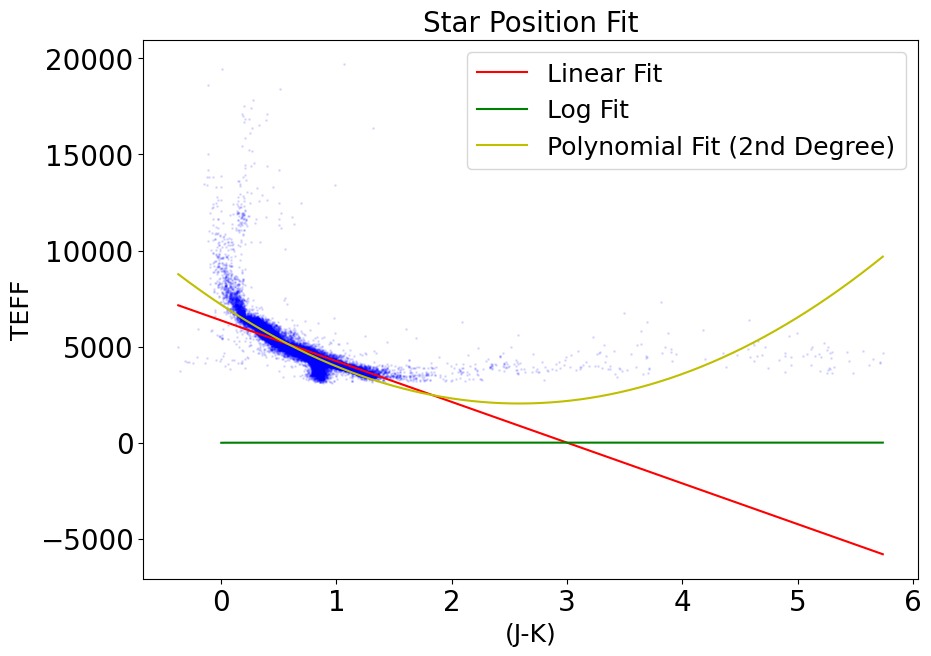

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def linear(x, a, b):
    return a * x + b

def log_fit(x, a, b):
    return a * np.log(x) + b

def polynomial2(x, a, b, c):
    return a * x**2 + b * x + c




ct1 = (star['DEC'] < -50) & (star['RA'] > 50) & (star['RA'] < 120)
cut1 = np.where(ct1)[0]

jk_data = star['J'][cut1] - star['K'][cut1]
jk_err = np.sqrt(star['J_ERR'][cut1]**2 + star['K_ERR'][cut1]**2)


teff_data = star['TEFF'][cut1]


valid_indices = ~np.isnan(jk_data) & ~np.isnan(teff_data) & ~np.isinf(jk_data) & ~np.isinf(teff_data)

jk_clean = jk_data[valid_indices]
teff_clean = teff_data[valid_indices]


initial_guess_linear = [1, 0] 

params_linear, _ = curve_fit(linear, jk_clean, teff_clean, p0=initial_guess_linear)

slope = params_linear[0]
intercept = params_linear[1]

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')


initial_guess_log = [1, 1]  

params_log, _ = curve_fit(log_fit, jk_clean, teff_clean, p0=initial_guess_log)

log_a = params_log[0]
log_b = params_log[1]

print(f'LOG FIT: a = {log_a:.3f}, b = {log_b:.3f}')


initial_guess_poly2 = [1, 1, 1]  

params_poly2, _ = curve_fit(polynomial2, jk_clean, teff_clean, p0=initial_guess_poly2)

poly2A = params_poly2[0]
poly2B = params_poly2[1]
poly2C = params_poly2[2]

print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')


fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(jk_clean, teff_clean, s=1, c='b', alpha=0.1)


ax1.set_xlabel('(J-K)', fontsize=18)
ax1.set_ylabel('TEFF', fontsize=18)
ax1.set_title('Star Position Fit', fontsize=20)


x_plot = np.linspace(min(jk_clean), max(jk_clean), 1000)
ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Linear Fit', color='r')
ax1.plot(x_plot, log_fit(x_plot, log_a, log_b), label='Log Fit', color='g')
ax1.plot(x_plot, polynomial2(x_plot, poly2A, poly2B, poly2C), label='Polynomial Fit (2nd Degree)', color='y')


plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: -0.006, -3.198
POLY2: -0.000, 0.089, -7.663
COSFIT: -14.113, 0.104, -11.562, -3.853


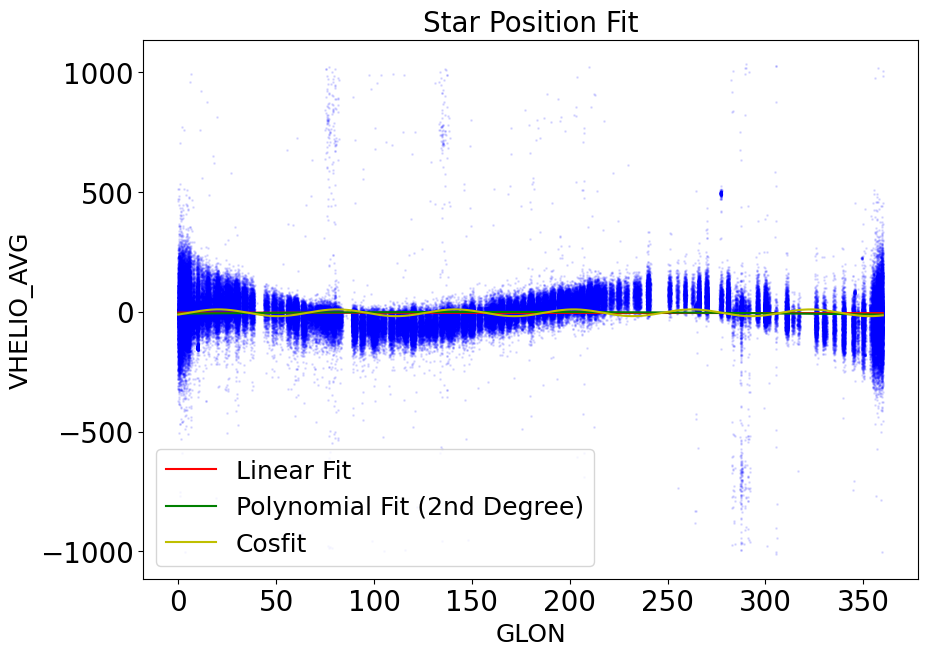

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def linear(x, a, b):
    return a * x + b

def polynomial2(x, a, b, c):
    return a * x**2 + b * x + c

def cosfit(x, a, b, c, d):
    return a * np.cos(b * x + c) + d




ct1 = (star['GLAT'] > -10) & (star['GLAT'] < 10)
cut1 = np.where(ct1)[0]


glon_data = star['GLON'][cut1]
vhelo_data = star['VHELIO_AVG'][cut1]

valid_indices = ~np.isnan(glon_data) & ~np.isnan(vhelo_data) & ~np.isinf(glon_data) & ~np.isinf(vhelo_data)

glon_clean = glon_data[valid_indices]
vhelo_clean = vhelo_data[valid_indices]


initial_guess_linear = [1, 0]  

params_linear, _ = curve_fit(linear, glon_clean, vhelo_clean, p0=initial_guess_linear)

slope = params_linear[0]
intercept = params_linear[1]

print(f'LINEAR: {slope:.3f}, {intercept:.3f}')


initial_guess_poly2 = [1, 1, 1]  

params_poly2, _ = curve_fit(polynomial2, glon_clean, vhelo_clean, p0=initial_guess_poly2)

poly2A = params_poly2[0]
poly2B = params_poly2[1]
poly2C = params_poly2[2]

print(f'POLY2: {poly2A:.3f}, {poly2B:.3f}, {poly2C:.3f}')


initial_guess_cosfit = [1, 0.1, 0, 1] 
params_cosfit, _ = curve_fit(cosfit, glon_clean, vhelo_clean, p0=initial_guess_cosfit)

cosfit_params_a = params_cosfit[0]
cosfit_params_b = params_cosfit[1]
cosfit_params_c = params_cosfit[2]
cosfit_params_d = params_cosfit[3]

print(f'COSFIT: {cosfit_params_a:.3f}, {cosfit_params_b:.3f}, {cosfit_params_c:.3f}, {cosfit_params_d:.3f}')


fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

ax1.scatter(glon_clean, vhelo_clean, s=1, c='b', alpha=0.1)


ax1.set_xlabel('GLON', fontsize=18)
ax1.set_ylabel('VHELIO_AVG', fontsize=18)
ax1.set_title('Star Position Fit', fontsize=20)


x_plot = np.linspace(min(glon_clean), max(glon_clean), 1000)
ax1.plot(x_plot, linear(x_plot, slope, intercept), label='Linear Fit', color='r')
ax1.plot(x_plot, polynomial2(x_plot, poly2A, poly2B, poly2C), label='Polynomial Fit (2nd Degree)', color='g')
ax1.plot(x_plot, cosfit(x_plot, cosfit_params_a, cosfit_params_b, cosfit_params_c, cosfit_params_d), label='Cosfit', color='y')


plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: a=0.078, b=1.218
EXPONENTIAL: a=0.000, b=1.000, c=-80.339
POLY3: a=0.000, b=-0.011, c=0.256, d=0.742


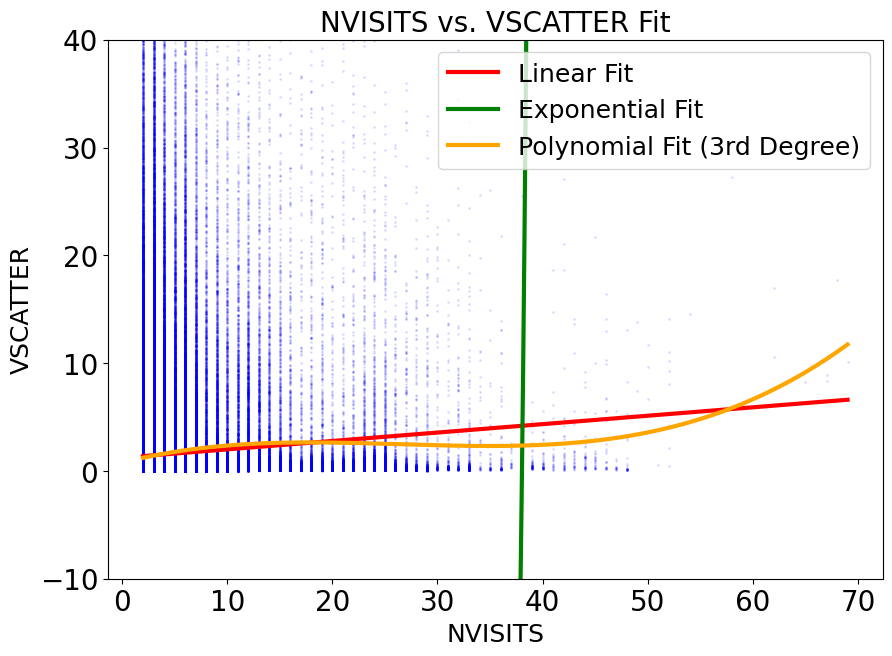

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def linear(x, a, b):
    return a * x + b

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def polynomial3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


ct1 = (star['NVISITS'] >= 2)
cut1 = np.where(ct1)[0]


nvisits_data = star['NVISITS'][cut1]
vscatter_data = star['VSCATTER'][cut1]

valid_indices = ~np.isnan(nvisits_data) & ~np.isnan(vscatter_data) & ~np.isinf(nvisits_data) & ~np.isinf(vscatter_data)

nvisits_clean = nvisits_data[valid_indices]
vscatter_clean = vscatter_data[valid_indices]


params_linear, _ = curve_fit(linear, nvisits_clean, vscatter_clean)

a_linear, b_linear = params_linear
print(f'LINEAR: a={a_linear:.3f}, b={b_linear:.3f}')


params_exp, _ = curve_fit(exponential, nvisits_clean, vscatter_clean, maxfev=10000)

a_exp, b_exp, c_exp = params_exp
print(f'EXPONENTIAL: a={a_exp:.3f}, b={b_exp:.3f}, c={c_exp:.3f}')


params_poly3, _ = curve_fit(polynomial3, nvisits_clean, vscatter_clean)

a_poly3, b_poly3, c_poly3, d_poly3 = params_poly3
print(f'POLY3: a={a_poly3:.3f}, b={b_poly3:.3f}, c={c_poly3:.3f}, d={d_poly3:.3f}')

fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(nvisits_clean, vscatter_clean, s=1, c='b', alpha=0.1)


ax1.set_xlabel('NVISITS', fontsize=18)
ax1.set_ylabel('VSCATTER', fontsize=18)
ax1.set_title('NVISITS vs. VSCATTER Fit', fontsize=20)


line_width = 3
x_plot = np.linspace(min(nvisits_clean), max(nvisits_clean), 1000)
ax1.plot(x_plot, linear(x_plot, a_linear, b_linear), label='Linear Fit', color='red', linewidth=line_width)
ax1.plot(x_plot, exponential(x_plot, a_exp, b_exp, c_exp), label='Exponential Fit', color='green', linewidth=line_width)
ax1.plot(x_plot, polynomial3(x_plot, a_poly3, b_poly3, c_poly3, d_poly3), label='Polynomial Fit (3rd Degree)', color='orange', linewidth=line_width)


ax1.set_ylim([-10, 40])  


plt.legend(loc='best', fontsize=18)
plt.show()


## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

LINEAR: a=0.197, b=-0.230
POLY2: a=-0.665, b=0.235, c=-0.225
POLY3: a=-0.153, b=-0.591, c=0.365, d=-0.227


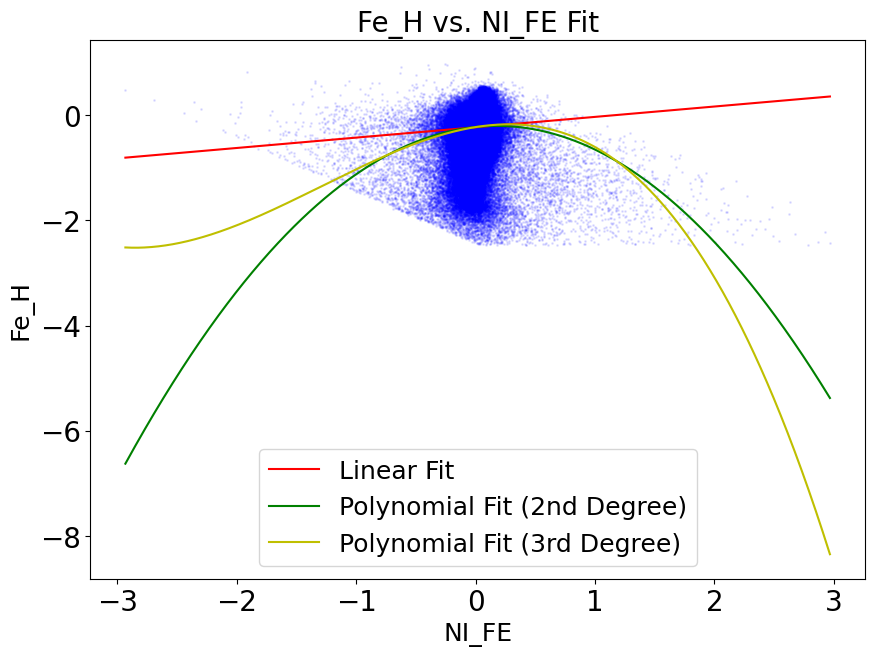

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def linear(x, a, b):
    return a * x + b

def polynomial2(x, a, b, c):
    return a * x**2 + b * x + c

def polynomial3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

valid_indices = ~np.isnan(star['Fe_H_ERR']) & ~np.isnan(star['NI_FE_ERR']) & ~np.isinf(star['Fe_H_ERR']) & ~np.isinf(star['NI_FE_ERR'])

fe_h_data = star['Fe_H'][valid_indices]
fe_h_err_data = star['Fe_H_ERR'][valid_indices]
ni_fe_data = star['NI_FE'][valid_indices]
ni_fe_err_data = star['NI_FE_ERR'][valid_indices]

params_linear_fe_h, _ = curve_fit(linear, ni_fe_data, fe_h_data)
a_linear_fe_h, b_linear_fe_h = params_linear_fe_h
print(f'LINEAR: a={a_linear_fe_h:.3f}, b={b_linear_fe_h:.3f}')


params_poly2_fe_h, _ = curve_fit(polynomial2, ni_fe_data, fe_h_data)
a_poly2_fe_h, b_poly2_fe_h, c_poly2_fe_h = params_poly2_fe_h
print(f'POLY2: a={a_poly2_fe_h:.3f}, b={b_poly2_fe_h:.3f}, c={c_poly2_fe_h:.3f}')

params_poly3_fe_h, _ = curve_fit(polynomial3, ni_fe_data, fe_h_data)
a_poly3_fe_h, b_poly3_fe_h, c_poly3_fe_h, d_poly3_fe_h = params_poly3_fe_h
print(f'POLY3: a={a_poly3_fe_h:.3f}, b={b_poly3_fe_h:.3f}, c={c_poly3_fe_h:.3f}, d={d_poly3_fe_h:.3f}')


fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)


ax1.scatter(ni_fe_data, fe_h_data, s=1, c='b', alpha=0.1)


ax1.set_xlabel('NI_FE', fontsize=18)
ax1.set_ylabel('Fe_H', fontsize=18)
ax1.set_title('Fe_H vs. NI_FE Fit', fontsize=20)


x_plot = np.linspace(min(ni_fe_data), max(ni_fe_data), 1000)
ax1.plot(x_plot, linear(x_plot, a_linear_fe_h, b_linear_fe_h), label='Linear Fit', color='r')
ax1.plot(x_plot, polynomial2(x_plot, a_poly2_fe_h, b_poly2_fe_h, c_poly2_fe_h), label='Polynomial Fit (2nd Degree)', color='g')
ax1.plot(x_plot, polynomial3(x_plot, a_poly3_fe_h, b_poly3_fe_h, c_poly3_fe_h, d_poly3_fe_h), label='Polynomial Fit (3rd Degree)', color='y')

plt.legend(loc='best', fontsize=18)
plt.show()
